# Table of Contents

<a class="anchor" id="abstract"></a>
The end goal is to be able to create a web application that automatically group comments/feedback from customers as well as highlight positive and negative sentiment of the comments.

This notebook shows in detail how to load/clean the data and how the functions needed to build an app are created. All the code demonstrated in this notebook is used to create the final app. There are two main tasks: 
1. Automatically grouping comments from customers and 
2. Highlight positive and negative sentiment of the comments. 

The first task uses the [IBM Debater - Thematic Clustering of Sentences](https://developer.ibm.com/exchanges/data/all/thematic-clustering-of-sentences/) dataset to cluster the text into various groups. The second task uses the [IBM's Debater - Sentiment Composition Lexicons](https://developer.ibm.com/exchanges/data/all/sentiment-composition-lexicons/) dataset to categorize feedback on a sentence level, or as a whole, with a range of sentiments. The goal of these functions is to allow companies to view comments in a more organized manner and to more easily view customers’ specific positive or negative feedback.

The code for the actual Python Flask app can be found in the directory `comments_organizer_app`. However, to actually use this framework, you must deploy the two main functions which is demonstrated in the notebook `2_Model_Deployment.ipynb`. See `README.md` for more detailed instructions.

* [1. Clustering Text](#clustering-text)
    * [1.1 Load Data](#1-1)
    * [1.2 Preprocessing Data](#1-2)
    * [1.3 Modeling](#1-3)
    * [1.4 Testing Model](#1-4)
    * [1.5 Example](#1-5)
* [2. Sentiment Analysis](#sentiment)
    * [2.1 Load Data](#2-1)
    * [2.2 Unigrams](#2-2)
    * [2.3 Bigrams](#2-3)
    * [2.4 Using Composition and Adjective Classes](#2-4)
    * [2.5 Combining Unigram, Bigram, Component/Adj Classes](#2-5)
    * [2.6 Group by Overall Sentiment](#2-6)
* [3. Example Combining 1 and 2](#combine)
* [4. Graphs](#graphs)

# 1. Clustering Text <a class="anchor" id="clustering-text"></a>
For this section, we will use the [IBM Debater - Thematic Clustering of Sentences](https://developer.ibm.com/exchanges/data/all/thematic-clustering-of-sentences/) dataset. We will use the dataset to test a clustering algorithm. Then this clustering algorithm will be used on a simple comments example. We will:
* 1.1 Load the Thematic Clustering of Sentences dataset.
* 1.2 Preprocess the dataset to be used for testing
* 1.3 Create a clustering model
    * Input a TFIDF matrix to KMeans Model
    * We determine the best number of clusters using [silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
* 1.4 Test the clustering model with the dataset
    * We evaluate the model using [V-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html), which is the harmonic mean between [homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score) and [completedness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)
* 1.5 Run the model with example comments

##  1.1 Load Data <a class="anchor" id="1-1"></a>

In [1]:
# Install required libraries
!pip install plotly==4.8.2 
!pip install wordcloud==1.7.0

In [2]:
import itertools
import os
import requests
import tarfile
from collections import defaultdict

import string
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

import matplotlib.pyplot as plt 
import plotly.graph_objs as go
# 
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def download_data(url_base, version, data_file_name):
    # Downloading the dataset
    url = "{}/{}/{}".format(url_base, version, data_file_name)
    response = requests.get(url)

    # Check for errors
    if not response.ok:
        print("There are some errors when downloading {}".format(url))

    # Open tar file
    with open(data_file_name, 'wb') as file_name:
        file_name.write(response.content)
    
def extract_data(data_directory, data_file_name):
    # Extracting the dataset
    with tarfile.open(data_file_name) as file_name:
        file_name.extractall(path='./' + data_directory)
    

In [4]:
# Download the dataset
data_directory = 'data/thematic-clustering-of-sentences'
url_base = 'https://dax-cdn.cdn.appdomain.cloud/dax-thematic-clustering-of-sentences'
version = '1.0.2'
data_file_name = 'thematic-clustering-of-sentences.tar.gz'
download_data(url_base, version, data_file_name)

In [5]:
# Extract the dataset
extract_data(data_directory, data_file_name)

In [6]:
# Read data
data_file = "dataset.csv"
data_path = os.path.join(data_directory, data_file)
if not os.access(data_path, os.R_OK):
    print("Failed to read the target file: {}".format(data_path))
    
clustering_df = pd.read_csv(data_path, encoding="ISO-8859-1")

In [7]:
clustering_df.head()

Article Title                                           Sentence  \
0  Moeller High School  Moeller's student-run newspaper, The Crusader,...   
1  Moeller High School  In 2008, The Crusader won First Place, the sec...   
2  Moeller High School  The Squire is a student literary journal that ...   
3  Moeller High School  Paul Keels - play-by-play announcer for Ohio S...   
4  Moeller High School           Joe Uecker - Ohio State Senator (R-66) .   

            SectionTitle                                       Article Link  
0   School publications   https://en.wikipedia.org/wiki/Moeller_High_School  
1   School publications   https://en.wikipedia.org/wiki/Moeller_High_School  
2   School publications   https://en.wikipedia.org/wiki/Moeller_High_School  
3        Notable alumni   https://en.wikipedia.org/wiki/Moeller_High_School  
4        Notable alumni   https://en.wikipedia.org/wiki/Moeller_High_School

##  1.2 Preprocessing Data <a class="anchor" id="1-2"></a>
In order for this data to be used to evaluate a clustering model, we need to assign them clusters. According to the readme file of the dataset, each cluster is each sectionTitle. Thus, you can combine the "Article Title" and "SectionTitle" to get a group. 

We will add columns in the dataset to more easily show the cluster. `label` is the unique string while `label_id` is a unique number.

In [8]:
clustering_df['label'] = clustering_df.apply(lambda row: row['Article Title'].replace(" ", "_") + ":" + row['SectionTitle'].replace(" ", "_"), axis=1)
clustering_df['label_id'] = clustering_df.label.astype('category').cat.codes
clustering_df.head()

Article Title                                           Sentence  \
0  Moeller High School  Moeller's student-run newspaper, The Crusader,...   
1  Moeller High School  In 2008, The Crusader won First Place, the sec...   
2  Moeller High School  The Squire is a student literary journal that ...   
3  Moeller High School  Paul Keels - play-by-play announcer for Ohio S...   
4  Moeller High School           Joe Uecker - Ohio State Senator (R-66) .   

            SectionTitle                                       Article Link  \
0   School publications   https://en.wikipedia.org/wiki/Moeller_High_School   
1   School publications   https://en.wikipedia.org/wiki/Moeller_High_School   
2   School publications   https://en.wikipedia.org/wiki/Moeller_High_School   
3        Notable alumni   https://en.wikipedia.org/wiki/Moeller_High_School   
4        Notable alumni   https://en.wikipedia.org/wiki/Moeller_High_School   

                                       label  label_id  
0  Moeller_High_School:_School_publications_      3414  
1  Moeller_High_School:_School_publications_      3414  
2  Moeller_High_School:_School_publications_      3414  
3       Moeller_High_School:_Notable_alumni_      3413  
4       Moeller_High_School:_Notable_alumni_      3413

We can create a dictionary mapping the label ID to the label name.

In [9]:
id_to_category = dict( enumerate(clustering_df.label.astype('category').cat.categories) )

If we take a look at the number of sentences that correspond to each cluster (label), we see that one cluster has a lot more sentences.

In [10]:
# One group has a lot more sentences. 
clustering_df.label_id.value_counts()

32      1308
27       164
30       126
4240      94
3013      91
        ... 
493        3
4591       3
5371       3
2604       3
3579       3
Name: label_id, Length: 5555, dtype: int64

In [11]:
id_to_category[32]

'1980_Birthday_Honours:United_Kingdom_and_Colonies'

We remove this cluster from our dataset because when we test, we want to keep groups together. Having this one very large group may not be an accurate representation of the real data.

In [12]:
# Remove rows in that top category
top_id = clustering_df.label_id.value_counts().index[0] 
df = clustering_df.loc[(clustering_df.label != id_to_category[top_id])]

In [13]:
df.head()

Article Title                                           Sentence  \
0  Moeller High School  Moeller's student-run newspaper, The Crusader,...   
1  Moeller High School  In 2008, The Crusader won First Place, the sec...   
2  Moeller High School  The Squire is a student literary journal that ...   
3  Moeller High School  Paul Keels - play-by-play announcer for Ohio S...   
4  Moeller High School           Joe Uecker - Ohio State Senator (R-66) .   

            SectionTitle                                       Article Link  \
0   School publications   https://en.wikipedia.org/wiki/Moeller_High_School   
1   School publications   https://en.wikipedia.org/wiki/Moeller_High_School   
2   School publications   https://en.wikipedia.org/wiki/Moeller_High_School   
3        Notable alumni   https://en.wikipedia.org/wiki/Moeller_High_School   
4        Notable alumni   https://en.wikipedia.org/wiki/Moeller_High_School   

                                       label  label_id  
0  Moeller_High_School:_School_publications_      3414  
1  Moeller_High_School:_School_publications_      3414  
2  Moeller_High_School:_School_publications_      3414  
3       Moeller_High_School:_Notable_alumni_      3413  
4       Moeller_High_School:_Notable_alumni_      3413

Next, we set the features to be `Sentence` which is all the text data we are interested in. We are predicting the `label_id`. Below we see that there are 5554 (1 removed) clusters and on average 8 sentences are in each cluster.

In [14]:
X = df.Sentence
y = df.label_id

print('Total data rows: ', len(X))
print('Unique groups: ', len(y.unique()))
print('Average number of rows per group: ', clustering_df.label_id.value_counts().mean())

Total data rows:  44809
Unique groups:  5554
Average number of rows per group:  8.301890189018902


To test a model, we will break this dataset into smaller datasets because in the real world, we likely would not want to have 5000 unique clusters. So we will split the data so that each set has about 5 clusters. To do this, we will randomly take 5000 of the 5554 clusters, then split this into 1000 sets. Now we have 1000 sets to test on (`list_of_groups`).

In [15]:
np.random.seed(42)  # get reproducible results
number_of_groups = 1000
sampled_categories = np.random.choice(y.unique(), size=5000)
list_of_groups = np.split(sampled_categories, number_of_groups)  # 5 categories in each group

##  1.3 Modeling <a class="anchor" id="1-3"></a>

Now that we have processed data to test the model, 
in this section, we will create the clustering model. We will:
1. Create a TF-IDF matrix using the input text. You will notice that in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) there are parameters:
    * max_df=0.75 means that all terms in more than 75% of documents will be ignored
    * min_df=0.1 means that all terms in less than 10% of documents will be ignored
    * stop_words='english' means Sklearn's stop words are removed from the input data
    * ngram_range = (1,3) means that unigrams, bigrams, and trigrams are used
2. Then this matrix is used in a KMeans model.
    * Number of clusters is input.
    * If no number of clusters is input then we determine the best number of clusters using [silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
3. Additionally, a function is written to extract the top terms used to cluster the text.


In [16]:
def get_top_n_terms_per_cluster(km_model, terms, n=5):
    """
    Gets the top terms used to cluster text

    :param km_model: KMeans model
    :param terms: list of terms from a TfidfVecotrizer object
    :return: dictionary mapping cluster number to top n terms
             {cluster_number: [term1, term2,..., termn]}
    """
    cluster_terms = defaultdict(list)

    tfidf_values = km_model.cluster_centers_
    order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
    for i in range(len(order_centroids)):
        cluster = order_centroids[i]
        for term_idx in cluster[:n]:
            # Term should exist in the cluster in order to include
            if tfidf_values[i, term_idx] != 0:
                cluster_terms[i].append(terms[term_idx])

    return cluster_terms

In [17]:
def run_kmeans(number_of_clusters, tfidf_matrix):
    """
    :param number_of_clusters: int
    :param tfidf_matrix: matrix from TfidfVectorizer object
    :return: KMeans model, list of cluster labels
    """
    km_model = KMeans(n_clusters=number_of_clusters, init='k-means++')
    km_model.fit(tfidf_matrix.toarray())
    clusters = km_model.labels_.tolist()
    return km_model, clusters

In [18]:
def run_model(X, number_of_clusters=None, number_of_terms=5, max_number_of_groups=5):
    """
    Runs the entire modeling process
    1. create TFIDF matrix
    2. run KMeans with TFIDF matrix
    3. get top terms used
    
    :return: (list of cluster assignments, 
              dictionary mapping cluster number of terms)
    """
    # First find TFIDF matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=0.75 if len(X)>1 else 1, 
                                       min_df=0.1 if len(X)>1 else 1,
                                       stop_words='english',
                                       use_idf=True, 
                                       ngram_range=(1,3),
                                      )

    tfidf_matrix = tfidf_vectorizer.fit_transform(X)
    terms = tfidf_vectorizer.get_feature_names()
    
    # Number of clusters must be > 2 for silhouette_score to work.
    # If there are 2 or less comments, then just set to number of comments.
    number_of_clusters = len(X) if len(X) <= 2 else number_of_clusters
    
    if number_of_clusters:
        # If there's a specific number of clusters specified, then run with that number.
        km_model, best_clusters = run_kmeans(number_of_clusters, tfidf_matrix)
        cluster_terms = get_top_n_terms_per_cluster(km_model, terms, n=number_of_terms)
    else:
        # Automatically find number of clusters with silhouette_score
        # but have a maximum of max_number_of_groups 
        max_silhouette_score = 0
        for k in range(2, min(max_number_of_groups, len(X))):
            km_model, clusters = run_kmeans(k, tfidf_matrix)
            current_silhouette_score = silhouette_score(tfidf_matrix, clusters)
            if current_silhouette_score > max_silhouette_score:
                max_silhouette_score = current_silhouette_score
                cluster_terms = get_top_n_terms_per_cluster(km_model, terms, n=number_of_terms)
                best_clusters = clusters
            
    return best_clusters, cluster_terms

##  1.4 Testing Model <a class="anchor" id="1-4"></a>

Next, we can test the clustering model with the dataset we downloaded and preprocessed in sections 1.1 and 1.2. We evaluate the model using [V-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html), which is the harmonic mean between [homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score) and [completedness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score). The higher the number, the better the model is, values are between 0 and 1.

Additionally, we create a baseline model that predicts random clusters for each input. We want our clustering model defined in 1.3 to do better than this baseline.

In [19]:
def run_model_testing(list_of_groups, df, test_size=50):
    average_homogeneity_score, average_completeness, average_v_measure = 0, 0, 0
    avg_baseline_score = 0

    for group in list_of_groups[:test_size]:
        X_test = list(df[df.label_id.isin(list(group))].Sentence.values)
        y_test = list(df[df.label_id.isin(list(group))].label_id.values)
        n = len(df[df.label_id.isin(list(group))].label_id.unique())
        
        clusters, cluster_terms = run_model(X_test)
        
        average_homogeneity_score += homogeneity_score(y_test, clusters)
        average_completeness += completeness_score(y_test, clusters)
        average_v_measure += v_measure_score(y_test, clusters)
        
        # baseline
        baseline_predictions = np.random.choice(np.arange(1, 5), len(X_test))
        avg_baseline_score += v_measure_score(y_test, baseline_predictions)

    
    print('Test V Measure:     ', average_v_measure/ test_size)
    print('Baseline V Measure: ', avg_baseline_score / test_size)


We see that our model actually does do much better than randomly picking clusters.

In [20]:
run_model_testing(list_of_groups, df)

<ipython-input-17-ef590fcbb371>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  km_model.fit(tfidf_matrix.toarray())


Test V Measure:      0.5093090727803768
Baseline V Measure:  0.16331723189348785


##  1.5 Example <a class="anchor" id="1-5"></a>

Finally, we use a sample of comments a retail company could see and run the model on it.

In [21]:
comments_5 = [
    'Customer service was polite.',
    'The socks are a pretty color but expensive.',
    'The shirt I bought was green and service was great.',
    'I think the sweater and socks were perfect.',
    'I do not like the shoes, so ugly and expensive.',
]

comments_20 = [
    'Out of all the products I bought, the shirt was my favorite because it is comfortable. However, the sweater and socks really missed the mark and were not worth it.',
    'My order arrived several days late. But when I contacted customer service they were very helpful and refunded me.',
    'Horrible customer service, I have never met such rude people. Would not recommend at all.',
    'Everything I ordered arrived perfectly on time and looked exactly like in the pictures! This company has high quality products.',
    'The company is okay.',
    'Prices are ridiculous',
    'Way too overpriced.',
    'Can never find anything that fits right',
    'Nice clothes for your teenager.',
    'They were really well organized and made the experience way less stressful than i thought it would be',
    'Friendly staff, good range of clothes.',
    'Fashionable place',
    'Decent quality product! Friendly customer service',
    'I really love all the clothes, beautiful. Just a little too expensive',
    'Great quality of the items, cashier and stocker were very friendly.',
    'Ugly and overpriced.'
    'This place was okay and I did find a couple plain shirts for cheap. Overall disappointed with their selection of basics and prices.',
    'Rude employees. Horrible customer service and limited clothing. Only good thing is cheap clothing',
    'Service was good and I got a lot for my money',
    'My favorite brand',
]

In [22]:
def print_clustering_result(sentences, labels, top_terms):
    label_to_sentences = defaultdict(list)
    for i in range(len(labels)):
        label_to_sentences[labels[i]].append(sentences[i])
    
    number_of_groups = len(label_to_sentences.keys())
    for i in range(number_of_groups):
        print('---------------------------------------')
        print('Group {}. Top Terms: {}'.format(i, top_terms[i]))
        for j in range(len(label_to_sentences[i])):
            print('- ' + label_to_sentences[i][j])

In [23]:
# Automatically determine number of clusters.
# However can also add the parameter e.g. number_of_clusters=5
for comments in [comments_5, comments_20]:
    best_labels, top_terms = run_model(comments)
    print_clustering_result(comments, best_labels, top_terms)
    print('\n\n')

---------------------------------------
Group 0. Top Terms: ['expensive', 'socks', 'pretty color expensive', 'color', 'color expensive']
- The socks are a pretty color but expensive.
- I think the sweater and socks were perfect.
- I do not like the shoes, so ugly and expensive.
---------------------------------------
Group 1. Top Terms: ['service', 'polite', 'service polite', 'customer', 'customer service']
- Customer service was polite.
- The shirt I bought was green and service was great.



---------------------------------------
Group 0. Top Terms: ['favorite', 'really', 'quality', 'products', 'way']
- Out of all the products I bought, the shirt was my favorite because it is comfortable. However, the sweater and socks really missed the mark and were not worth it.
- Everything I ordered arrived perfectly on time and looked exactly like in the pictures! This company has high quality products.
- They were really well organized and made the experience way less stressful than i thought 

# 2. Sentiment Analysis <a class="anchor" id="sentiment"></a>
For this section, we use [IBM's Debater - Sentiment Composition Lexicons](https://developer.ibm.com/exchanges/data/all/sentiment-composition-lexicons/) dataset. Our goal here is to take text and capture sentiment on the entire text as well as for each sentence in the text. We base our model on [this paper](https://www.aclweb.org/anthology/C18-1189.pdf) (by creators of this dataset). Our final model is section 2.5, which combines 2.2 to 2.4. So in the following subsections, we:

* 2.1 Load Data
* 2.2 Create method that uses 'LEXICON_UG.txt' to match unigrams to sentiment score
* 2.3 Create method that uses 'LEXICON_BG.txt' to match bigrams to sentiment score
* 2.4 Create method that uses the rules from Table 1 of the paper to produce sentiment scores. This method essentially matches bigrams to certain rules that produce a predicted polarity (positive or negative)
* 2.5 Combines 2.2 to 2.4. 
    * We first get bigrams of the text. Then to determine the sentiment of each bigram we will:
        1. Take the bigram score (2.2, calulate_bigram_sentiment()). If this does not exist then,
        2. Take the score from matching component/adjective classes (2.3, calculate_compostion_or_adj_sentiment()). If this does not exist then,
        3. Look at the unigrams (2.1, calulate_bigram_sentiment()) of the bigram. Both words need to be negative in order to be negative (similarly for positive). If one is positive and one negative then it is neutral
        * Positive bigram score = +1, Negative bigram score = -1, Neutral bigram score = 0
    * To determine final sentiment of a sentence, the sentiment score of each bigram is added together.
    * To determine final sentiment of entire text, the sentiment score of each sentence is added together. 
* 2.6 Using 2.5, demonstrate examples of grouping comments by sentiment as well as hilighting sentiment on a sentence level.

## 2.1 Load Data <a class="anchor" id="2-1"></a>

In [24]:
# Download the dataset
sentiment_data_directory = 'data/sentiment-composition-lexicons'
url_base = 'https://dax-cdn.cdn.appdomain.cloud/dax-sentiment-composition-lexicons'
version = '1.0.2'
data_file_name = 'sentiment-composition-lexicons.tar.gz'
download_data(url_base, version, data_file_name)

In [25]:
# Extract the dataset
extract_data(sentiment_data_directory, data_file_name)

## 2.2 Unigrams <a class="anchor" id="2-2"></a>

In [26]:
# Read unigram data
unigram_df = pd.read_csv(os.path.join(sentiment_data_directory, 'LEXICON_UG.txt'), sep=" ")

# Add sentiment column
unigram_df['sentiment'] = np.where(unigram_df['SENTIMENT_SCORE'] > 0, 1, 0)  # 1 is positive, 0 is negative
unigram_df.head()

UNIGRAM  SENTIMENT_SCORE  sentiment
0      aa         0.019674          1
1     aaa         0.032775          1
2    aaas         0.074593          1
3  aachen         0.011926          1
4     aah         0.118070          1

In [27]:
unigram_sentiment_dict = pd.Series(unigram_df.SENTIMENT_SCORE.values,
                                   index=unigram_df.UNIGRAM.values).to_dict()

In [28]:
# Simple implementation: if finds token in unigram_sentiment_dict, then adds sentiment
# The total sentiment for sentence is averaged
def calculate_unigram_sentiment(tokenized_sentence, sentiment_map=unigram_sentiment_dict):
    sentiment_score = 0
    for token in tokenized_sentence:
        token_sentiment = sentiment_map.get(token)
        if token_sentiment is None:
            continue
        else:
            sentiment_score += token_sentiment

    return sentiment_score

In [29]:
# Print out example sentences and their sentiment.
# The more negative the score, the more negative the sentiment.
# The more positive the score, the more positive the sentiment.
for sentence in comments_5:
    score = calculate_unigram_sentiment(word_tokenize(sentence.lower()))
    print('Score: {}, Sentence: {}'.format(score, sentence))

Score: 0.7981163, Sentence: Customer service was polite.
Score: -0.26573172, Sentence: The socks are a pretty color but expensive.
Score: 0.1841142, Sentence: The shirt I bought was green and service was great.
Score: 0.1615984, Sentence: I think the sweater and socks were perfect.
Score: -1.1203735, Sentence: I do not like the shoes, so ugly and expensive.


## 2.3 Bigrams <a class="anchor" id="2-3"></a>

In [30]:
# Read bigram data
bigrams_df = pd.read_csv(os.path.join(sentiment_data_directory, 'LEXICON_BG.txt'), sep=" ")

# Add sentiment column
bigrams_df['sentiment'] = np.where(bigrams_df['SENTIMENT_SCORE'] > 0, 1, 0)  # 1 is positive, 0 is negative
bigrams_df.head()

BIGRAM POS_TAGS  SENTIMENT_SCORE  sentiment
0       abalone-divers   NN-NNS        -0.090230          0
1    abandoned-animals  VBN-NNS        -0.089895          0
2  abandoned-apartment   VBN-NN        -0.126907          0
3   abandoned-attempts  VBN-NNS        -0.053709          0
4     abandoned-babies  VBN-NNS        -0.074742          0

In [31]:
bigram_sentiment_dict = pd.Series(bigrams_df.SENTIMENT_SCORE.values,
                                   index=bigrams_df.BIGRAM.str.split('-').apply(lambda l: tuple(l))).to_dict()

In [32]:
def calculate_bigram_sentiment_sentence(sentence_bigrams):
    bigrams = []
    bigram_sentiment_score = 0
    for bigram in sentence_bigrams:
        bigram_sentiment = calculate_bigram_sentiment(bigram)
        if bigram_sentiment is not None:
            bigram_sentiment_score += bigram_sentiment
            bigrams.append(bigram)
    
    return bigram_sentiment_score, bigrams


def calculate_bigram_sentiment(bigram):
    bigram_sentiment = bigram_sentiment_dict.get(bigram)
    if bigram_sentiment:
        # -0.02 and 0.02 allows for margin of error for neutrals
        if bigram_sentiment < -0.02:
            return -1
        elif bigram_sentiment > 0.02:
            return 1
        else:
            return 0
    return None

In [33]:
sentence = 'The high prices are ridiculous'
sentence2 = 'They do not accept payments from my credit card'
calculate_bigram_sentiment_sentence(list(nltk.bigrams(word_tokenize(sentence.lower()))))
calculate_bigram_sentiment_sentence(list(nltk.bigrams(word_tokenize(sentence2.lower()))))

(1, [('accept', 'payments')])

## 2.4 Using Composition and Adjective Classes <a class="anchor" id="2-4"></a>

Here, we will uses the rules from Table 1 of [this paper](https://www.aclweb.org/anthology/C18-1189.pdf) (by creators of this dataset), to produce sentiment scores. We will essentially match bigrams to certain rules that produce a predicted polarity (positive or negative). There are two groups of rules: composition classes and adjective classes. Adjective classes focus on the adjective pairs (high, low) and (fast, slow).

In order to do this, there are two files: 1) ADJECTIVES.xlsx and 2) SEMANTIC_CLASSES.xlsx. The adjectives files contains 5 sheets, the first sheet gives a list of words similar to each of high, low, fast, slow. The next four sheets are words that are associated with that specific case. 

The semantic classes file has 6 sheets, one for each of the composition classes defined in the paper. In each sheet, there is a list of words that corresponds to that composition class.


### 2.4.1 Reading Adjective Classes Data Files

First, we will read in ADJECTIVE_EXPANSION.xlsx and clean it up.

In [34]:
xls_file = pd.ExcelFile(os.path.join(sentiment_data_directory, 'ADJECTIVES.xlsx'))
adjective_expansion = pd.read_excel(xls_file, 'ADJECTIVE_EXPANSION').dropna(how='all').reset_index(drop=True)
high_low_PN = pd.read_excel(xls_file, '(HIGH,LOW)_POS_NEG', header=None)[0].values.tolist()
high_low_NP = pd.read_excel(xls_file, '(HIGH,LOW)_NEG_POS', header=None)[0].values.tolist()
fast_slow_PN = pd.read_excel(xls_file, '(FAST,SLOW)_POS_NEG', header=None)[0].values.tolist()
fast_slow_NP = pd.read_excel(xls_file, '(FAST,SLOW)_NEG_POS', header=None)[0].values.tolist()


def clean_adjective_df(df):
    adjectives = []
    for i in range(4):
        adjectives.extend(df.iloc[:, i+1].dropna().tolist())
    
    adj_category = df.iloc[0,0]
    
    return [(adj, adj_category) for adj in adjectives]


tokens = []
token_rows = 5
for i in range(0, len(adjective_expansion), token_rows+1):
    tokens.append(clean_adjective_df(adjective_expansion.loc[i:i+token_rows]))
high_tokens, low_tokens, fast_tokens, slow_tokens = tokens

adjective_class_map = dict(high_tokens + low_tokens + fast_tokens + slow_tokens)

In [35]:
set(adjective_class_map.values())

{'FAST_TOKENS', 'HIGH_TOKENS', 'LOW_TOKENS', 'SLOW_TOKENS'}

Now we have a dictionary that matches words to the adjective class (fast, high, low, slow). The dictionary looks like:
{word: adjective_class}

### 2.4.2 Reading Compostion Classes Data Files

Next, we read the SEMANTIC_CLASSES.xlsx file

In [36]:
semantic_classes_file = pd.ExcelFile(os.path.join(sentiment_data_directory, 'SEMANTIC_CLASSES.xlsx'))

dominator_neg = pd.read_excel(semantic_classes_file, 'DOMINATOR_NEG', header=None)[0].values.tolist()
dominator_pos = pd.read_excel(semantic_classes_file, 'DOMINATOR_POS', header=None)[0].values.tolist()
propagator_pos = pd.read_excel(semantic_classes_file, 'PROPAGATOR_POS', header=None)[0].values.tolist()
propagator_neg = pd.read_excel(semantic_classes_file, 'PROPAGATOR_NEG', header=None)[0].values.tolist()
reverser_pos = pd.read_excel(semantic_classes_file, 'REVERSER_POS', header=None)[0].values.tolist()
reverser_neg = pd.read_excel(semantic_classes_file, 'REVERSER_NEG', header=None)[0].values.tolist()

### 2.4.3 Matching Adjective/Composition Classes
Now we write a method to match bigrams to an adjective or composition class. The bigram matching order will be, as stated in the paper: ADJ (adjective), REV (reverse), PROP (propagator), DOM (dominator)

In [37]:
class Adjective:
    FAST = 'FAST_TOKENS'
    SLOW = 'SLOW_TOKENS'
    HIGH = 'HIGH_TOKENS'
    LOW = 'LOW_TOKENS'
    
class Sign:
    POSITIVE = 'Positive'
    NEGATIVE = 'Negative'
    NEUTRAL = 'Neutral'

adjective_conditions = {
    Adjective.FAST: [(fast_slow_PN, Sign.POSITIVE), (fast_slow_NP, Sign.NEGATIVE)],
    Adjective.SLOW: [(fast_slow_PN, Sign.NEGATIVE), (fast_slow_NP, Sign.POSITIVE)],
    Adjective.HIGH: [(high_low_PN, Sign.POSITIVE), (high_low_NP, Sign.NEGATIVE)],
    Adjective.LOW: [(high_low_PN, Sign.NEGATIVE), (high_low_NP, Sign.POSITIVE)],
}

sentiment_to_score = {
    Sign.POSITIVE: +1,
    Sign.NEGATIVE: -1,
}

def is_given_sentiment(sentiment, word, sentiment_map):
    if word in sentiment_map:
        if sentiment==Sign.NEGATIVE and sentiment_map[word] < 0:
            return True
        elif sentiment==Sign.POSITIVE and sentiment_map[word] > 0:
            return True

def calculate_composition_or_adj_sentiment(bigram):
    # Adjective
    adjective_token = adjective_class_map.get(bigram[0])
    if adjective_token is not None:
        for expansions_list, sentiment_sign in adjective_conditions[adjective_token]:
            if bigram[1] in expansions_list:
                return sentiment_to_score[sentiment_sign]

    # Composition: Reverser
    elif bigram[0] in reverser_pos and is_given_sentiment(Sign.NEGATIVE, bigram[1], unigram_sentiment_dict):
        return sentiment_to_score[Sign.POSITIVE]
    elif bigram[0] in reverser_neg and is_given_sentiment(Sign.POSITIVE, bigram[1], unigram_sentiment_dict):
        return sentiment_to_score[Sign.NEGATIVE]

    # Composition: Propagator
    elif bigram[0] in propagator_pos and is_given_sentiment(Sign.NEGATIVE, bigram[0], unigram_sentiment_dict) and is_given_sentiment(Sign.POSITIVE, bigram[1], unigram_sentiment_dict):
        return sentiment_to_score[Sign.POSITIVE]
    elif bigram[0] in propagator_neg and is_given_sentiment(Sign.POSITIVE, bigram[0], unigram_sentiment_dict) and is_given_sentiment(Sign.NEGATIVE, bigram[1], unigram_sentiment_dict):
        return sentiment_to_score[Sign.NEGATIVE]

    # Composition: Dominator
    elif bigram[0] in dominator_neg:
        return sentiment_to_score[Sign.NEGATIVE]
    elif bigram[0] in dominator_pos:
        return sentiment_to_score[Sign.POSITIVE]
    
    return None
    
        
def calculate_composition_or_adj_sentiment_sentence(sentence):
    sentiment_count = 0
    bigrams = []
    sentence_bigrams = list(nltk.bigrams(word_tokenize(sentence.lower())))
    for bigram in sentence_bigrams:
        sentiment = calculate_composition_or_adj_sentiment(bigram)
        if sentiment is not None:
            sentiment_count += sentiment
            bigrams.append(bigram)
        else:
            continue 
            
    # if sentiment_count > 0 then positive
    return sentiment_count, bigrams

We can now calculate the sentiment of sentences. For example:

In [38]:
calculate_composition_or_adj_sentiment_sentence("The high prices are ridiculous")

(-1, [('high', 'prices')])

A value < 0 means a negative sentiment and a value > 0 means positive. Thus, in the example above, that sentence has a negative sentiment. The tuple printed out is the bigram that was matched to determine the sentiment.

## 2.5 Combining Unigram, Bigram, Component/Adj Classes <a class="anchor" id="2-5"></a>

In this section, we combine the techniques from 2.1 to 2.3 to calculate sentiment. We will first get bigrams of the text. Then to determine the final sentiment of each bigram we will:
1. Take the bigram score (2.2, calulate_bigram_sentiment()). If this does not exist then,
2. Take the score from matching component/adj (2.3, calculate_compostion_or_adj_sentiment()). If this does not exist then,
3. Look at the unigrams (2.1, calulate_bigram_sentiment()) of the bigram. Both words need to be negative in order to negative (similar for positive). If one is positive and one negative then it is neutral

In [39]:
def calculate_sentiment_combined(sentence):
    sentiment_score = 0
    table = str.maketrans(dict.fromkeys(string.punctuation))
    cleaned_sentence = sentence.translate(table)  # remove punctuation
    sentence_bigrams = list(nltk.bigrams(word_tokenize(cleaned_sentence.lower())))
    
    for bigram in sentence_bigrams:
        current_sentiment = calculate_bigram_sentiment(bigram)
        if current_sentiment is None:
            current_sentiment = calculate_composition_or_adj_sentiment(bigram)
            if current_sentiment is None:
                unigram_sentiment = calculate_unigram_sentiment(bigram)
                if unigram_sentiment < - 0.1:
                    current_sentiment = -1
                elif unigram_sentiment > 0.1:
                    current_sentiment = 1
                else:
                    current_sentiment = 0
        
        sentiment_score += current_sentiment
    
    return sentiment_score
    

Example using the combined model. As stated previously, a score < 0 is negative sentiment, score > 0 is positive, and score = 0 is neutral.

In [40]:
extra_sentences = ['The high prices are ridiculous', 
                   'They do not accept payments from my credit card',
                   'I absolutely love how nice they are, I would definitely buy again from here.',
                   'I hate their products, so horrible, I cannot believe I spent so much money on shoes.',
                   'However, their webiste is beautiful and modern.',
                  ]
sentiment_sentences = comments_5 + extra_sentences

for sentence in sentiment_sentences:
    score = calculate_sentiment_combined(sentence)
    print('Score: {}, Sentence: {}'.format(score, sentence))

Score: 2, Sentence: Customer service was polite.
Score: -1, Sentence: The socks are a pretty color but expensive.
Score: -1, Sentence: The shirt I bought was green and service was great.
Score: -1, Sentence: I think the sweater and socks were perfect.
Score: -3, Sentence: I do not like the shoes, so ugly and expensive.
Score: -3, Sentence: The high prices are ridiculous
Score: 0, Sentence: They do not accept payments from my credit card
Score: 7, Sentence: I absolutely love how nice they are, I would definitely buy again from here.
Score: -2, Sentence: I hate their products, so horrible, I cannot believe I spent so much money on shoes.
Score: 3, Sentence: However, their webiste is beautiful and modern.


## 2.6 Group by Overall Sentiment <a class="anchor" id="2-5"></a>
Group by the comment's overall sentiment. Within each comment, label the postive/negative sentences.

In [41]:
def convert_score_to_sentiment(score):
    if score < 0:
        return Sign.NEGATIVE
    elif score > 0:
        return Sign.POSITIVE
    else:
        return Sign.NEUTRAL
    

def calculate_sentence_level_sentiment(comment_by_sentence):
    """
    :param comment_by_sentence: comment broken down by sentence [sentence1, sentence2, ...]
                                each sentence is string.
    :return: (overall_score, [(sentiment, sentence), ...])
    """
    sentence_level_sentiment = []
    overall_score = 0
    for sentence in comment_by_sentence:
        score = calculate_sentiment_combined(sentence)
        overall_score += score
        sentiment_sentence_pair = (convert_score_to_sentiment(score), sentence)
        sentence_level_sentiment.append(sentiment_sentence_pair)
    return overall_score, sentence_level_sentiment
    

def group_comments_by_sentiment(comments):
    """
    :param comments: [comment, comment, ...]
    :return: {Pos: [[(+/-, sentence1), (+/-, sentence2), ...], [...], [...], ...]
              Neg: [], Neutral: [], }
    """
    overall_sentiment = defaultdict(list)
    for comment in comments:
        comment_by_sentence = nltk.tokenize.sent_tokenize(comment)
        overall_score, sentence_level_sentiment = calculate_sentence_level_sentiment(comment_by_sentence)
        overall_sentiment[convert_score_to_sentiment(overall_score)].append(sentence_level_sentiment)

    return overall_sentiment

### Example

In [42]:
comments = [
    'I bought several items: socks, shirt, sweater. By far my most favorite was the shirt because it is so soft. However, the sweater and socks missed the mark.',
    'My order arrived several days late. But when I contacted customer serivce they were very helpful and refunded me.',
    'Horrible, horrible customer service, I have never met such rude people. Why is it so bad? Would not recommend at all.',
    'Everything I ordered arrived on time and looked exactly like in the pictures! This company has high quality products.',
    'I bought somethings on sale, they were a great deal. Will be buying more next time.'
]

overall_sentiment = group_comments_by_sentiment(comments)
sign_word_to_symbol = {Sign.NEGATIVE: '-', Sign.POSITIVE: '+', Sign.NEUTRAL: '='}

# print out results in readible way
for sign in overall_sentiment:
    print('{}:'.format(sign))
    for comment in overall_sentiment[sign]:
        sentence_printout_text = ''
        for sentence_sign, sentence in comment:
            sentence_printout_text += '({}) {}\n'.format(sign_word_to_symbol[sentence_sign], sentence)
        print(sentence_printout_text)

Negative:
(-) I bought several items: socks, shirt, sweater.
(-) By far my most favorite was the shirt because it is so soft.
(-) However, the sweater and socks missed the mark.

(-) Horrible, horrible customer service, I have never met such rude people.
(-) Why is it so bad?
(-) Would not recommend at all.

Positive:
(-) My order arrived several days late.
(+) But when I contacted customer serivce they were very helpful and refunded me.

(+) I bought somethings on sale, they were a great deal.
(=) Will be buying more next time.

Neutral:
(-) Everything I ordered arrived on time and looked exactly like in the pictures!
(+) This company has high quality products.



# 3. Combining Sentiment and Clustering <a class="anchor" id="combine"></a>

Given input sentences, we will now group them as well as label them as Neutral, Postive, or Negative.

## 3.1 Group by Topic and Show Overall Sentiment <a class="anchor" id="3-1"></a>

In [43]:
def print_result(sentences, labels):
    sentiment_scores = [calculate_sentiment_combined(sentence) for sentence in sentences]
    
    label_to_sentences = defaultdict(list)
    for i in range(len(labels)):
        label_to_sentences[labels[i]].append((sentences[i], 
                                              convert_score_to_sentiment(sentiment_scores[i])))
    
    number_of_groups = len(label_to_sentences.keys())
    for i in range(number_of_groups):
        print('Group {}'.format(i))
        for j in range(len(label_to_sentences[i])):
            print('- {} ({})'.format(label_to_sentences[i][j][0], label_to_sentences[i][j][1]))


In [44]:
def run_sentiment_and_clustering(input_sentences):
    final_labels, top_terms = run_model(input_sentences)
    print_result(input_sentences, final_labels)

In [45]:
run_sentiment_and_clustering(comments_5)

Group 0
- The socks are a pretty color but expensive. (Negative)
- I think the sweater and socks were perfect. (Negative)
- I do not like the shoes, so ugly and expensive. (Negative)
Group 1
- Customer service was polite. (Positive)
- The shirt I bought was green and service was great. (Negative)


In [46]:
run_sentiment_and_clustering(comments)

Group 0
- My order arrived several days late. But when I contacted customer serivce they were very helpful and refunded me. (Positive)
- Horrible, horrible customer service, I have never met such rude people. Why is it so bad? Would not recommend at all. (Negative)
Group 1
- I bought several items: socks, shirt, sweater. By far my most favorite was the shirt because it is so soft. However, the sweater and socks missed the mark. (Negative)
- Everything I ordered arrived on time and looked exactly like in the pictures! This company has high quality products. (Neutral)
- I bought somethings on sale, they were a great deal. Will be buying more next time. (Positive)


### 3.1.1 Highlight Negative/Positive Sentences

Example of grouping comments as well as showing sentiment of each sentence in each comment.

In [47]:
final_labels, top_terms = run_model(comments)

# [ [(sentiment, sentence), (), ...], [], ...]
sentence_sentiment_scores = []
sentiment_scores = []
for comment in comments:
    comment_sentences = nltk.tokenize.sent_tokenize(comment)
    overall_sentiment, sentence_sentiment = calculate_sentence_level_sentiment(comment_sentences)
    sentence_sentiment_scores.append(sentence_sentiment)
    sentiment_scores.append(overall_sentiment)

# {group_number: (overall_sentiment, sentence_sentiment_scores)}
label_to_comments = defaultdict(list)
for i in range(len(final_labels)):
    label_to_comments[final_labels[i]].append((convert_score_to_sentiment(sentiment_scores[i]), 
                                               sentence_sentiment_scores[i]
                                              ))

number_of_groups = len(label_to_comments.keys())
for i in range(number_of_groups):
    print('### GROUP {} ###'.format(i))
    for j in range(len(label_to_comments[i])):
        print('* Comment overall sentiment: ({})'.format(label_to_comments[i][j][0]))
        
        for k in range(len(label_to_comments[i][j][1])):
            sentence_sign = label_to_comments[i][j][1][k][0]
            sentence = label_to_comments[i][j][1][k][1]
            print('  ({}) {}'.format(sign_word_to_symbol[sentence_sign], sentence))
        
        print('\n')


### GROUP 0 ###
* Comment overall sentiment: (Negative)
  (-) I bought several items: socks, shirt, sweater.
  (-) By far my most favorite was the shirt because it is so soft.
  (-) However, the sweater and socks missed the mark.


* Comment overall sentiment: (Neutral)
  (-) Everything I ordered arrived on time and looked exactly like in the pictures!
  (+) This company has high quality products.


* Comment overall sentiment: (Positive)
  (+) I bought somethings on sale, they were a great deal.
  (=) Will be buying more next time.


### GROUP 1 ###
* Comment overall sentiment: (Positive)
  (-) My order arrived several days late.
  (+) But when I contacted customer serivce they were very helpful and refunded me.


* Comment overall sentiment: (Negative)
  (-) Horrible, horrible customer service, I have never met such rude people.
  (-) Why is it so bad?
  (-) Would not recommend at all.




# 4 Graphs <a class="anchor" id="graphs"></a>

In [48]:
def get_top_n_words(corpus, n=None):
    count_vect = CountVectorizer(stop_words='english')
    matrix = count_vect.fit_transform(corpus)
    frequencies = zip(count_vect.get_feature_names(), matrix.sum(axis=0).tolist()[0])
    words_freq = sorted(frequencies, key=lambda x: -x[1])
    return words_freq[:n]

In [49]:
common_words = get_top_n_words(comments, 5)
most_freq_words = pd.DataFrame(common_words, columns = ['Words' , 'count'])

data = [go.Bar(
    x=most_freq_words['Words'],
    y=most_freq_words['count'],
)]

fig = go.Figure(data=data)
fig.update_layout(
    title="Top 5 words in comments",
    xaxis_title="Word",
    yaxis_title="Count"
)

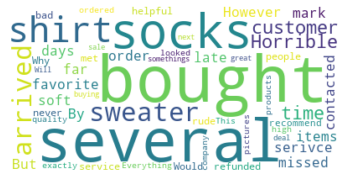

In [50]:
wc = WordCloud(background_color="white")
wc.generate(' '.join(comments))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019, 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**